In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import pyjet
import fastjet as fj
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
qcd_data = pd.read_hdf('events_LHCO2020_backgroundMC_Pythia.h5')
sig_data = pd.read_hdf('events_LHCO2020_BlackBox1.h5')

N_Jets and Dijet invariant mass

In [23]:
def run(data,n_events=1000):
    
    out = []
    njets = []
    
    # Loop over events
    for ievt in range(n_events):

        # Build a list of all particles
        pjs = []
        for i in range(int(data.shape[1]/3)):
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data.at[ievt,3*i+0],data.at[ievt,3*i+1],data.at[ievt,3*i+2],0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt() > 30. and abs(j.eta()) < 4.7]

        out.append([jets[0],jets[1]])
        njets.append(len(jets))
                
    return out, njets

In [24]:
out_qcd, njetsqcd = run(qcd_data)
out_sig, njetssig = run(sig_data)

Text(0, 0.5, 'Events per bin')

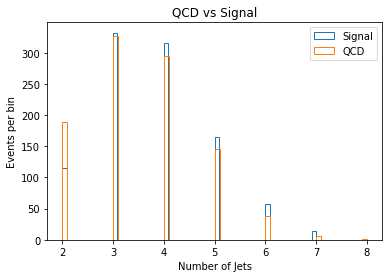

In [25]:
_ = plt.hist(njetssig, label="Signal", bins=60, histtype='step')
_ = plt.hist(njetsqcd, label="QCD", bins=60, histtype='step')
plt.legend()
plt.title('QCD vs Signal')
plt.xlabel('Number of Jets')
plt.ylabel('Events per bin')
#plt.savefig('njets.png')

Text(0, 0.5, 'Events per bin')

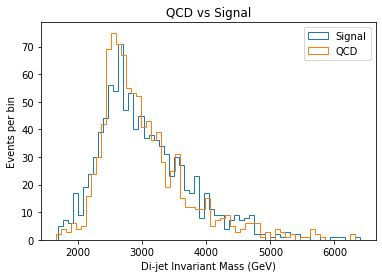

In [26]:
# Extract the leading dijet mass for signal..
dijet_m_sig = []
for evt in out_sig:
    dijet_m_sig.append( (evt[0]+evt[1]).m())

# ..and background
dijet_m_qcd = []
for evt in out_qcd:
    dijet_m_qcd.append( (evt[0]+evt[1]).m())

# and plot
_ = plt.hist(dijet_m_sig,label="Signal",bins=60,histtype='step')
_ = plt.hist(dijet_m_qcd,label="QCD",bins=60,histtype='step')
plt.legend()
plt.title('QCD vs Signal')
plt.xlabel('Di-jet Invariant Mass (GeV)')
plt.ylabel('Events per bin')
#plt.savefig('QCD_sig_old.png')

MET Calculation

In [20]:
def run_met(data,n_events=1000):
    
    met = []
    
    # Loop over events
    for ievt in range(n_events):

        # Build a list of all particles
        pjmet = fj.PseudoJet()
        pjs = fj.PseudoJet()
        for i in range(int(data.shape[1]/3)):
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data.at[ievt,3*i+0],data.at[ievt,3*i+1],data.at[ievt,3*i+2],0)
            pjmet.reset_momentum(-pj.px(), -pj.py(), 0, pj.E())
            pjs = pjs + pjmet
        met.append(pjs)
                
    return met

Text(0, 0.5, 'Events per bin')

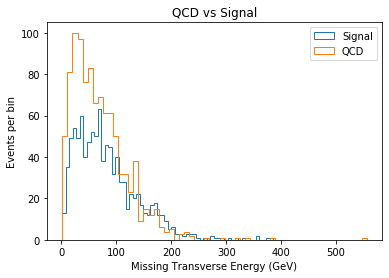

In [22]:
met_qcd = run_met(qcd_data)
met_sig = run_met(sig_data)
#for evt in met_qcd:
#    print("QCD MET: ", evt.pt(), evt.eta(), evt.phi())
#for evt in met_sig:
#    print("Sig MET: ", evt.pt(), evt.eta(), evt.phi())

met_pt_sig = []
for evt in met_sig:
    met_pt_sig.append(evt.pt())

met_pt_qcd = []
for evt in met_qcd:
    met_pt_qcd.append(evt.pt())

# and plot
_ = plt.hist(met_pt_sig,label="Signal",bins=60,histtype='step')
_ = plt.hist(met_pt_qcd,label="QCD",bins=60,histtype='step')
plt.legend()
plt.title('QCD vs Signal')
plt.xlabel('Missing Transverse Energy (GeV)')
plt.ylabel('Events per bin')
#plt.savefig('QCD_sig_old.png')

In [10]:
pj1 = fj.PseudoJet()
pj1.reset_PtYPhiM(3.5878686904907227, -2.3234722614288335, 3.6860645453082483, 0)
pj2 = fj.PseudoJet()
pj2.reset_PtYPhiM(1.4971730709075928, -2.4809937477111794, 4.013727966939108, 0)
pj = fj.PseudoJet()
pj = pj1 + pj2
print("Test: ", pj.pt(), pj.eta(), pj.phi())

Test:  5.02852581554909 -2.38342359954349 3.7820326469915617


In [11]:
pj1 = fj.PseudoJet()
pj1.reset_momentum(-3.0690662949602747, -1.8583954954052233, 0, 18.49367143681953)
pj2 = fj.PseudoJet()
pj2.reset_momentum(-0.9629712339577701, -1.1463915591196236, 0, 9.010584139847614)
pj = fj.PseudoJet()
pj = pj1 + pj2
print("Test: ", pj.pt(), pj.eta(), pj.phi())

Test:  5.02852581554909 0.0 3.782032646991562


Jets Area

In [93]:
def jet_area(data,ievt=8):
        
    # Build a list of all particles
    event = np.zeros(int(data.shape[1]/3), dtype=pyjet.DTYPE_PTEPM)
    for i in range(int(data.shape[1]/3)):
        event['pT'][i] = data.at[ievt,3*i+0]
        event['eta'][i] = data.at[ievt,3*i+1]
        event['phi'][i] = data.at[ievt,3*i+2]
                
    return event

In [94]:
# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200

In [95]:
event = jet_area(qcd_data)
#event = jet_area(sig_data)

# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

# add ghosts to the event
event = np.concatenate([event, ghosts], axis=0)

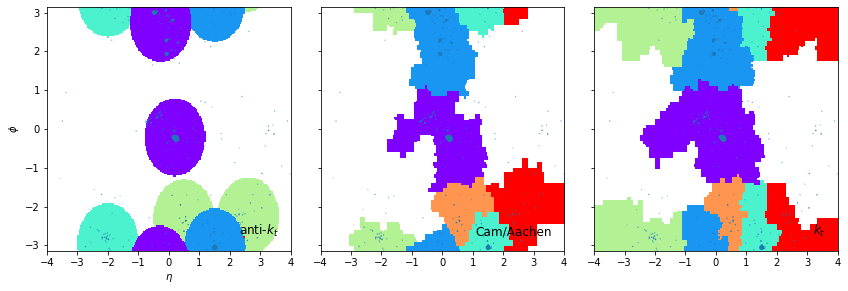

In [96]:
fig = plt.figure(figsize=(12, 4))

ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, R=1.0, p=p)
    jets = sequence.inclusive_jets(ptmin=30)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(jets):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = jet_area(qcd_data)
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, label,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()
#fig.savefig('jet_areas.png')

Testing Fastjet Techniques

In [132]:
def run_sel(data, ievt=0):
    
    out = []
    njets = []
    
    # Build a list of all particles
    pjs = []
    for i in range(int(data.shape[1]/3)):
        pj = fj.PseudoJet()
        pj.reset_PtYPhiM(data.at[ievt,3*i+0],data.at[ievt,3*i+1],data.at[ievt,3*i+2],0)
        pjs.append(pj)

    # run jet clustering with AntiKt, R=1.0
    R = 1.0
    jet_def = fj.JetDefinition(fj.antikt_algorithm, R)
    #jets = jet_def(pjs)
        
    #select_rapidity = fj.SelectorAbsRapMax(2.5)
    #select_pt = fj.SelectorPtMin(30.0)
    #select_both = select_pt and select_rapidity
        
    #jets_sel = (fj.SelectorNHardest(2))(jets)

    #jets_ghost = (fj.SelectorIsPureGhost())(jets)

    #ghost_maxrap = 4.0
    #area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(ghost_maxrap))
    #clust_seq = fj.ClusterSequenceArea(pjs, jet_def, area_def)
    #jets = fj.sorted_by_pt(clust_seq.inclusive_jets())
    #jets[0].area()

    #ghost_maxrap = 4.0
    #select_rapidity = fj.SelectorAbsRapMax(ghost_maxrap)
    #area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(ghost_maxrap))
    #bge = fj.JetMedianBackgroundEstimator(select_rapidity, jet_def, area_def)
    #bge.set_particles(pjs)
    #print(bge.rho())
    
    ghost_maxrap = 4.0
    area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(ghost_maxrap))
    clust_seq = fj.ClusterSequenceArea(pjs, jet_def, area_def)
    jets = fj.sorted_by_pt(clust_seq.inclusive_jets())
    select_rapidity = fj.SelectorAbsRapMax(4.0)
    bge = fj.JetMedianBackgroundEstimator(select_rapidity, jet_def, area_def)
    bge.set_particles(pjs)
    sub = fj.Subtractor(bge)
    sub_jets = sub(jets)
    for i in range(len(jets)):
        print(jets[i].pt(), sub_jets[i].pt())
    
    return True

In [133]:
run_sel(qcd_data, ievt=8)

1738.52192973992 1735.7166531502048
1165.9632877946865 1163.044465742712
546.7250853179789 543.9747101693597
66.32138252388006 63.550768459715215
49.105762937258454 47.40539291992089
37.787969820335576 35.53622037893819
16.894502766115934 14.430768867421735
8.7332850527509 7.009391126605346
6.8942595240968005 5.068894650769003
4.554199512886296 2.6459099042784744
3.818617044810417 1.8164835949872746
3.2421384906621604 2.2354206670752377
3.0035246814809664 1.5213207069675427
2.2646167877332726 0.0
1.394080400466919 0.5337346480497712
1.0864964723587036 0.0
1.0390360355377197 0.2591608083607902
1.0350549221038818 0.4147676438845493
1.0014251470565796 0.0
0.9757730364799498 0.5136899775570555
0.7080093789831062 0.0
0.5919121963749361 0.5919121963749361
0.5018376708030701 0.0
0.40955632925033564 0.40955632925033564
0.2608526647090912 0.0
0.0 0.0


True